In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password="varz@2001",
                            database = "ecommerce")

cur = db.cursor()


# List all unique cities where customers are located.


In [2]:
query = """select distinct upper((customer_city)) from customers"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df = df.head(5)
df

,0
0,FRANCA
1,SAO BERNARDO DO CAMPO
2,SAO PAULO
3,MOGI DAS CRUZES
4,CAMPINAS


# Count the number of orders placed in 2017

In [3]:
query = """SELECT count(order_id)FROM orders where year(order_purchase_timestamp) = 2017"""

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are",data[0][0]

('total orders placed in 2017 are', 135303)

# Find the total sales per category.


In [4]:
query = """select upper(products.product_category) category, round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["category" , "Sales"])
df

,category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


#  Calculate the percentage of orders that were paid in installments.


In [5]:
query = """SELECT (sum(case when payment_installments >= 1 then 1 else 0 end))/count(*)*100 from payments;"""

cur.execute(query)

data = cur.fetchall()

"Calculate the percentage of orders that were paid in installments is ",data

('Calculate the percentage of orders that were paid in installments is ',
 [(Decimal('99.9981'),)])

# Count the number of customers from each state

<function matplotlib.pyplot.show(close=None, block=None)>

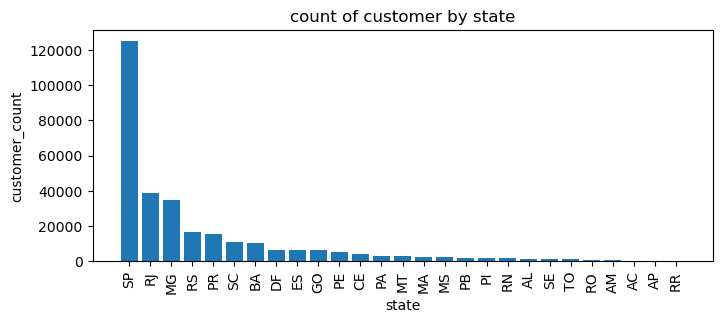

In [6]:
query = """SELECT customer_state , count(customer_id) from customers
group by customer_state;"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["state","ID"] )
df = df.sort_values(by = "ID",ascending = False)

plt.figure(figsize =(8,3))
plt.bar(df["state"],df["ID"])
plt.xlabel("state")
plt.ylabel("customer_count")
plt.title("count of customer by state")
plt.xticks(rotation = 90)
plt.show

#  Calculate the number of orders per month in 2018.


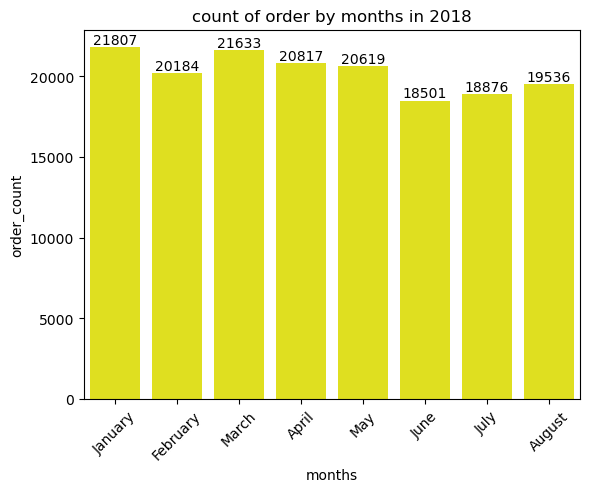

In [7]:
query = """SELECT monthname(order_purchase_timestamp) as months, count(order_id) as order_count 
FROM orders WHERE year(order_purchase_timestamp) = 2018 GROUP BY months;
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["months", "order_count"])

month_order = ["January", "February", "March", "April", "May", "June", 
               "July", "August"]

ax =sns.barplot(x="months", y="order_count", data=df, order=month_order,  color = "yellow") 
ax.bar_label(ax.containers[0])
plt.title("count of order by months in 2018")
plt.xticks(rotation = 45)
plt.show()

# Find the average number of products per order, grouped by customer city.


In [8]:
query = """WITH count_per_order AS (
    SELECT orders.order_id, orders.customer_id, COUNT(order_items.order_id) AS oc
    FROM orders
    JOIN order_items ON orders.order_id = order_items.order_id
    GROUP BY orders.order_id, orders.customer_id
)
SELECT customers.customer_city, round(avg(count_per_order.oc),2) AS avg_order_count
FROM customers
JOIN count_per_order ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city order by avg_order_count DESC;"""

cur.execute(query)

data = cur.fetchall()

df=pd.DataFrame(data , columns =["Customer City","Avg Order"])
df=df.head(10)
df

,Customer City,Avg Order
0,padre carvalho,21.00
1,celso ramos,19.50
2,datas,18.00
3,candido godoi,18.00
4,matias olimpio,15.00
5,cidelandia,12.00
6,curralinho,12.00
7,picarra,12.00
8,morro de sao paulo,12.00
9,teixeira soares,12.00


# Calculate the percentage of total revenue contributed by each product category.


In [9]:
query = """select upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payments.payment_value) from payments))*100,2) sales_percent
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
order by sales_percent DESC;"""

cur.execute(query)

data=cur.fetchall()
df = pd.DataFrame(data , columns = ["category","percentage"])
df=df.head(5)
df

,category,percentage
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


# Identify the correlation between product price and the number of times a product has been purchased.


In [11]:
query = """select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2) 
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category;"""

cur.execute(query)

data=cur.fetchall()
df = pd.DataFrame(data , columns=["category","order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]
a = np.corrcoef([arr1,arr2])
print("correaltion between no of times product has been purchase",a[0],[-1])

correaltion between no of times product has been purchase [ 1.         -0.10631514] [-1]


#  Calculate the total revenue generated by each seller, and rank them by revenue.


<function matplotlib.pyplot.show(close=None, block=None)>

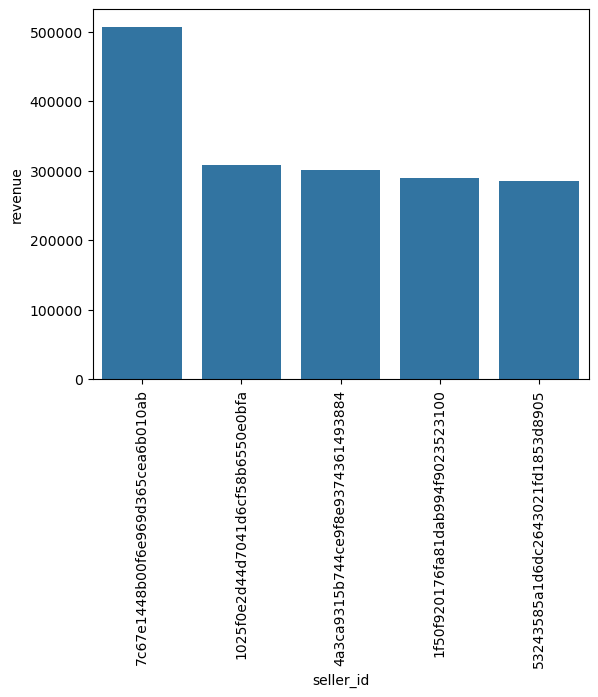

In [22]:
query = """ select * , dense_rank() over(order by revenue desc) as rn from 
(select order_items.seller_id , sum(payments.payment_value) revenue 
from order_items join payments on order_items.order_id = payments.order_id 
group by order_items.seller_id) as a  ;"""

cur.execute(query)

data=cur.fetchall()
df = pd.DataFrame(data , columns = ["seller_id","revenue","rank"])
df=df.head(5)
sns.barplot(x="seller_id" , y="revenue" , data = df)
plt.xticks(rotation = 90)
plt.show

#  Calculate the moving average of order values for each customer over their order history.

In [30]:
query = """ select customer_id, order_purchase_timestamp,payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row ) as mov_avg 
from
(select orders.customer_id,orders.order_purchase_timestamp , payments.payment_value as payment from payments
join orders on payments.order_id = orders.order_id) as a ;"""

cur.execute(query)

data=cur.fetchall()
df = pd.DataFrame(data)
df=df.head(10)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
4,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
5,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
6,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
7,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
8,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
9,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006


# Calculate the cumulative sales per month for each year.


In [32]:
query = """select years , months ,  payment ,sum(payment)
over(order by years , months) as cumulative_sales
from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment 
from orders join payments
on orders.order_id = payments.order_id 
group by years , months  
order by years , months) as a; """

cur.execute(query)

data=cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,756.72,756.72
1,2016,10,177271.44,178028.16
2,2016,12,58.86,178087.02
3,2017,1,415464.12,593551.14
4,2017,2,875724.03,1469275.17
5,2017,3,1349590.80,2818865.97
6,2017,4,1253364.09,4072230.06
7,2017,5,1778756.46,5850986.52
8,2017,6,1533829.14,7384815.66
9,2017,7,1777148.76,9161964.42


#  Calculate the year-over-year growth rate of total sales.


In [47]:
query = """ with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment 
from orders join payments
on orders.order_id = payments.order_id 
group by years   
order by years)

select years,((payment - LAG(payment) OVER (ORDER BY years)) / LAG(payment) OVER (ORDER BY years) * 100) from a"""

cur.execute(query)

data=cur.fetchall()
df = pd.DataFrame(data , columns = ["years","yoy%growth" ])
df

,years,yoy%growth
0,2016,NaN
1,2017,12112.703756
2,2018,20.000924


#  Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.


In [50]:
query = """ with a as (
select customers.customer_id,
min(orders.order_purchase_timestamp) as first_order
from customers 
join orders 
on customers.customer_id = orders.customer_id
group by customers.customer_id),


b as(select a.customer_id, count(distinct orders.order_purchase_timestamp) as next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order , interval 6 month)
group by a.customer_id )

select 100 * (count(distinct a.customer_id))/(count(distinct b.customer_id))
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)

data=cur.fetchall()
df = pd.DataFrame(data , columns =["retention rate of customer"])
df

,retention rate of customer
0,None


#  NONE OF CUSTOMERS HAVE A PURCHASE WITHIN A 6 MONTHS INTERVAL 

#  Identify the top 3 customers who spent the most money in each year.

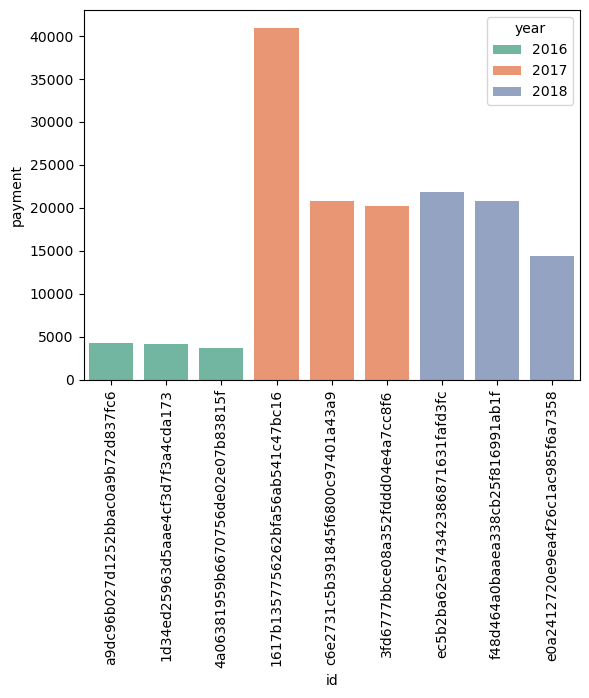

In [65]:
query = """ select years , customer_id , payment , d_rank 
from
(select year(orders.order_purchase_timestamp) as years, 
orders.customer_id,
sum(payments.payment_value) as payment,
dense_rank()over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) DESC) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp) ,orders.customer_id) as a
where d_rank <=3 ;"""

cur.execute(query)

data=cur.fetchall()
df = pd.DataFrame(data , columns = ["year" , "id" , "payment" , "D_rank"])
sns.barplot(x="id", y="payment", data=df, hue="year", palette="Set2")
plt.xticks(rotation = 90)
plt.show()
